In [13]:
import time
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utilities import *
%matplotlib inline
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import sklearn.preprocessing as prep
plt.rcParams['figure.figsize'] = (18, 12)

In [14]:
start_date = '2007-01-16'
end_date = '2015-01-16'
dates = pd.date_range(start_date, end_date)

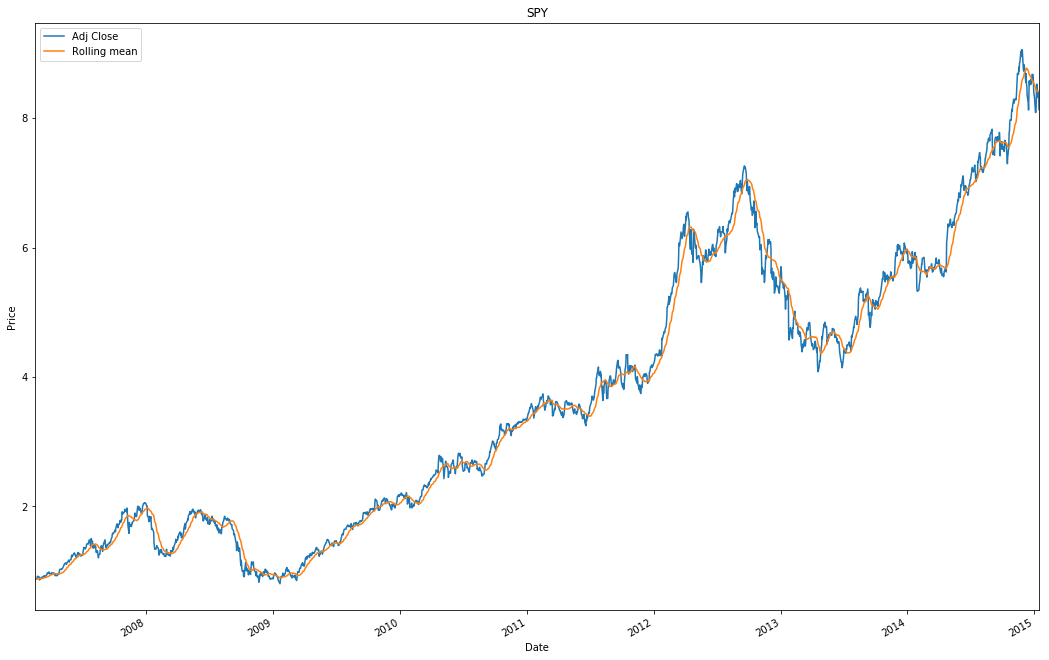

In [15]:
df_spy = get_data('AAPL', dates)
df_spy = df_spy.iloc[20:]

ax = df_spy.plot(title='SPY',y=['Adj Close', 'Rolling mean'])
ax.set(xlabel='Date', ylabel='Price')
plt.show()

In [16]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [41]:
def preprocess_data(data, seq_len=3, tt_split=0.90, normalise=False, pad=None): 
    
    sequence_length = seq_len + 1
    if (pad):
        sequence_length = pad+1
        #print('pad active')
    result = []
    data_np = np.array(data)
    data_fl = data_np.astype(np.float)
    bounds = [np.amin(data_fl), np.amax(data_fl)]

    for index in range(len(data) - sequence_length):
        if (pad):
            x = []
            for i in range(0, pad-seq_len):
                x.append(data[index])
            for i in range(0, seq_len+1):
                x.append(data[index + i])
        else:
            x = data[index: index + sequence_length]
        result.append(x)

    if normalise:
        result = normalise_all(result)
    print(result)
    result = np.array(result)

    row = round(tt_split * result.shape[0])
    train = result[:int(row), :]
    # np.random.shuffle(train)
    if (pad):
        offset = seq_len
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    #x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    #x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]

In [42]:

def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [43]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(df_spy.values, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

[array([[ 0.87229698,  0.46700187,  0.88739451],
       [ 0.87847593,  0.40832026,  0.88242541],
       [ 0.87754893,  0.2923142 ,  0.88043777],
       [ 0.87363548,  0.32141756,  0.87854796],
       [ 0.88465511,  0.49651484,  0.87808967],
       [ 0.91864075,  0.92865165,  0.87989194],
       [ 0.92183332,  0.67377277,  0.8813389 ],
       [ 0.91730185,  0.41628762,  0.88279101],
       [ 0.91153457,  0.4950249 ,  0.88440276],
       [ 0.86436675,  0.92101514,  0.88336775],
       [ 0.87136999,  0.73908258,  0.88288372],
       [ 0.89660157,  1.13781501,  0.88356859],
       [ 0.87960855,  0.69127619,  0.88391359],
       [ 0.88898063,  0.67431518,  0.88472203],
       [ 0.90823898,  0.58130417,  0.8869105 ],
       [ 0.90339854,  0.50341313,  0.88874882],
       [ 0.9062823 ,  0.41075548,  0.88970145],
       [ 0.90597317,  0.36318991,  0.89062318],
       [ 0.92554065,  0.58630515,  0.89402173],
       [ 0.9104017 ,  0.69761857,  0.89583429],
       [ 0.92687947,  0.64030312,  0.89

In [44]:
model = build_model([X_train.shape[2], window, 100, 1])

/home/machine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/home/machine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 3), units=20)`
  if __name__ == '__main__':


Compilation Time :  0.013491392135620117


/home/machine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


In [45]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=200,
    validation_split=0.1,
    verbose=0)

ValueError: Error when checking model target: expected activation_3 to have shape (None, 1) but got array with shape (1778, 3)

In [22]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.03 MSE (0.16 RMSE)
Test Score: 0.06 MSE (0.23 RMSE)


In [25]:
diff = []
ratio = []
pred = model.predict(X_test)

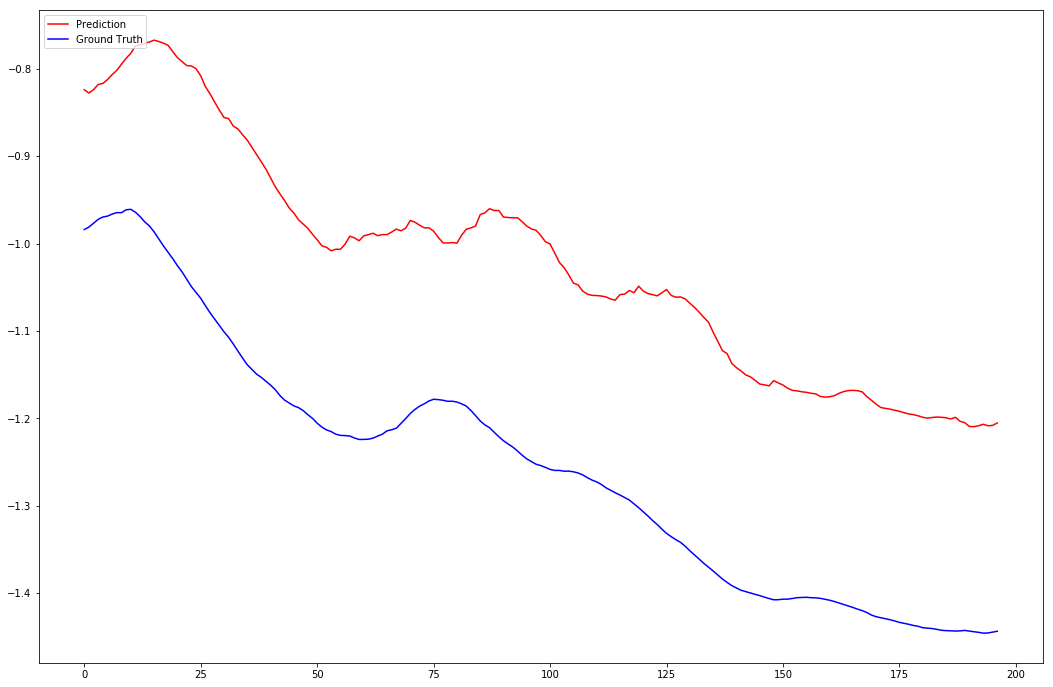

In [26]:
import matplotlib.pyplot as plt2

plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()